Compound identifiers are a mess.  We have 3 different sources of data, each with 3 different primary identifiers... Previously we used CTD (MESH), which also has some ChEBI terms included. Next we looked up records from Inxight Drugs, which happen to use UNII as the primary identifier.  We've converted as many as possilbe to Inchi-key.  Finally, we will be incorporating ReFRAME, which uses Inchi-key as the primary identifier. Many Steps will be required to get maximum overlap from the 3 data Sources.

1. We must resolve mappings from ChEBI to MeSH.
    - ChEBI and MeSH both have tree-like (ontology) structure and many higher-level terms (like chemical classes) are similar
    - Direct mappings between ChEBI and MeSH are difficult to come by
    - The following may have some direct mappings
        - mychem.info
        - wikidata
    - Indirect mappings through other Identifiers may also be useful
2. We need maps from this ChEBI/MeSH to UNII and InchiKey
    - ChEBI to Inchi-key is well definied 
    - inchikey to unii is only somewhat defined, large percnetage missing
3. String Matching will be usd as a last resort
    

In [1]:
import zipfile
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import tools.biothings_processing as bp
from tools.processing import expand_col_on_char, load_api_results, expand_split_col, expand_df_on_col
from tools.plot import venn2_pretty, venn3_pretty
from tools.obo_tools import get_ontology_edges, get_ontology_nodes, get_children, get_lineage

from wikidataintegrator.wdi_core import WDItemEngine

from hetnet_ml.src import graph_tools as gt

In [2]:
# Get Data Dir
data_dir = Path('../2_pipeline/00_download_data/out/').resolve()


# Get Output Directory ready
this_file = '09_Resolving_Chemical_Identifiers'
out_dir = Path('../2_pipeline/').resolve()
out_dir = out_dir.joinpath(this_file).joinpath('out')

if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [3]:
ix_nodes = pd.read_csv('../2_pipeline/08_More_Drug_to_Target_Edges/out/nodes_inxight.csv', dtype=str)
ix_nodes.head(2)

,id,name,label,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,unii_id,source,...,target_chembl_id,target_type,tax_id,id_source,xrefs,gene_symbol,organism,swissprot_entry,target_class,uniprot_id
0,FZERHIULMFGESH-UHFFFAOYSA-N,Acetanilide,Compound,CHEBI:28884,CHEMBL269644,NaN,FZERHIULMFGESH-UHFFFAOYSA-N,MESH:C508827,SP86R356CC,ikey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SWMPGCCDXNLPED-NSCUHMNNSA-N,Acetylfuratrizine,Compound,NaN,NaN,NaN,SWMPGCCDXNLPED-NSCUHMNNSA-N,MESH:C005910,C50C4V19SU,ikey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ix_nodes.head(2)

,id,name,label,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,unii_id,source,...,target_chembl_id,target_type,tax_id,id_source,xrefs,gene_symbol,organism,swissprot_entry,target_class,uniprot_id
0,FZERHIULMFGESH-UHFFFAOYSA-N,Acetanilide,Compound,CHEBI:28884,CHEMBL269644,NaN,FZERHIULMFGESH-UHFFFAOYSA-N,MESH:C508827,SP86R356CC,ikey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SWMPGCCDXNLPED-NSCUHMNNSA-N,Acetylfuratrizine,Compound,NaN,NaN,NaN,SWMPGCCDXNLPED-NSCUHMNNSA-N,MESH:C005910,C50C4V19SU,ikey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
comp_cols = ['id', 'name', 'label', 'chebi_id', 'chembl_id', 'drugbank_id', 'ikey', 'mesh_id', 'unii_id', 'source']
ix_comps = ix_nodes.query('label == "Compound"').loc[:,comp_cols]
len(ix_comps)

105893

In [6]:
prev_nodes = gt.remove_colons(pd.read_csv('../2_pipeline/07_Filter_non_human_annotations/out/nodes_filt.csv', dtype=str))
prev_comps = prev_nodes.query('label == "Compound"').copy()

prev_comps.head(2)

,id,name,label,tree_numbers,drug_bank_ids,alt_disease_ids,gene_symbol,alt_gene_ids,bio_gridids,pharm_gkbids,uni_prot_ids,uniprot_id,mesh_ids,chebi_ids
0,MESH:C046983,06-Paris-LA-66 protocol,Compound,D02.455.426.559.847.562.050.200/C046983|D03.13...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MESH:C534883,10074-G5,Compound,D03.383.129.462.580/C534883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
ref = pd.read_csv('../0_data/manual/reframe_merged.csv', dtype=str)
ref = ref.drop_duplicates().reset_index(drop=True)
ref.head(2)

,gvk_id,drug_name,phase,drug_roa,category,mechanism,sub_smiles,synonyms_gvk,ikey,name_inf,...,id,status,smiles_itg,name_itg,integrity_note,int_thera_group,int_MoA,wikidata_itg,PubChem CID,source
0,5916161.0,A-49816,Clinical Phase Unknown,NaN,High-Ceiling Diuretic,High-Ceiling Diuretic,Cl[H].[H]OC1=C(CN([H])[H])C=C(C=C1)C(=O)C2=CC=...,Abbott-49816,WYFYYAHANZQLGG-UHFFFAOYSA-N,NaN,...,145141.0,Clinical,CCOC(=O)COc1ccc(c(c1Cl)Cl)C(=O)c2ccc(c(c2)CN)O.Cl,A-49816,NaN,Diuretics,NaN,Q27270440,CID92009045,gvk|integrity
1,5913712.0,Elmustine,Clinical Phase Unknown,NaN,Anticancer,Anticancer,[H]OCCN([H])C(=O)N(CCCl)N=O,BRN-1956525|FFC-33|HECNU|Hecnu|NSC-294895,YJZJEQBSODVMTH-UHFFFAOYSA-N,Elmustine,...,91016.0,Phase III,C(CO)NC(=O)N(CCCl)N=O,Elmustine,NaN,Oncolytic Drugs,DNA-Damaging Drugs,Q27284767,CID68804,gvk|informa|integrity


In [8]:
len(ref)

17220

In [9]:
ref_ikeys = ref['ikey'].unique()
res = load_api_results(out_dir.joinpath('reframe_mychem_info_{}.pkl'), scrape_function=bp.download_mychem_ids, 
                         chem_ids=ref_ikeys)


ref_comps = bp.process_chemicals_in_mychem_results(res)

In [10]:
ref_comps.head(2)

,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,name,q,unii_id,id,source
0,NaN,CHEMBL543295,NaN,WYFYYAHANZQLGG-UHFFFAOYSA-N,NaN,A-49816 hydrochloride,WYFYYAHANZQLGG-UHFFFAOYSA-N,8GKF50WX7S,WYFYYAHANZQLGG-UHFFFAOYSA-N,ikey
1,NaN,CHEMBL284907,NaN,YJZJEQBSODVMTH-UHFFFAOYSA-N,MESH:C013876,Elmustine,YJZJEQBSODVMTH-UHFFFAOYSA-N,NAT2FD82D7,YJZJEQBSODVMTH-UHFFFAOYSA-N,ikey


In [11]:
len(ref_comps)

17091

In [12]:
# how many returned at least SOME kind of result?
len(ref_comps.drop('q', axis=1).dropna(how='all'))

14833

In [13]:
chebi = get_ontology_nodes(data_dir.joinpath('chebi.obo'), props=['http://purl.obolibrary.org/obo/chebi/inchikey'])
chebi = chebi.rename(columns={'http://purl.obolibrary.org/obo/chebi/inchikey': 'ikey'})
chebi.head(2)

,alt_id,def,ikey,id,is_obsolete,name,subset,xref,id_src
0,NaN,"""A chemical entity is a physical entity of int...",NaN,CHEBI:24431,False,chemical entity,3_STAR,NaN,CHEBI
1,NaN,"""Any constitutionally or isotopically distinct...",NaN,CHEBI:23367,False,molecular entity,3_STAR,NaN,CHEBI


In [14]:
len(chebi.dropna(subset=['ikey']))

92700

### Wikidata to query chebi to mesh

In [15]:
query = """
SELECT DISTINCT ?chebi ?mesh ?item ?itemLabel
WHERE 
{
  ?item wdt:P486 ?mesh.
  ?item wdt:P683 ?chebi.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?itemLabel
"""

In [16]:
chebi_to_mesh = WDItemEngine.execute_sparql_query(query, as_dataframe=True)

In [17]:
bad_mesh = chebi_to_mesh['mesh'].str.startswith('M')
bad_mesh = bad_mesh[bad_mesh].index
chebi_to_mesh = chebi_to_mesh.drop(bad_mesh)
chebi_to_mesh['chebi'] = 'CHEBI:' + chebi_to_mesh['chebi']
chebi_to_mesh['mesh'] = 'MESH:' + chebi_to_mesh['mesh']

In [18]:
ix = chebi_to_mesh['mesh'].duplicated(keep=False)
chebi_duped = chebi_to_mesh.loc[ix[ix].index]
len(chebi_duped)

698

These are instances of multiple CHEBI ids for a single WIKIDATA item... (where that item has at least 1 MESH id)

We will try to resolve these...

In [19]:
ix = chebi_to_mesh['chebi'].duplicated(keep=False)
mesh_duped = chebi_to_mesh.loc[ix[ix].index]
len(mesh_duped)

22

These are instances of a Mutiple MESH ids for a single WIKIDATA item (with at least one CHEBI id).

May be small enought to resolve

### Look at only the 1 to 1 mappings and see if we can merge to chebi ontology

In [20]:
unique_chebi_to_mesh = chebi_to_mesh.drop_duplicates(subset=['chebi'], keep=False).drop_duplicates(subset=['mesh'], keep=False)

In [21]:
len(unique_chebi_to_mesh)

4031

In [22]:
len(chebi)

113750

In [23]:
chebi = pd.merge(chebi, unique_chebi_to_mesh[['chebi', 'mesh']], how='left', left_on='id', right_on='chebi').drop('chebi', axis=1)

In [24]:
chebi.dropna(subset=['mesh']).sample(10)

,alt_id,def,ikey,id,is_obsolete,name,subset,xref,id_src,mesh
1304,NaN,"""A potassium salt that is the dipotassium salt...",KMUONIBRACKNSN-UHFFFAOYSA-N,CHEBI:53444,False,potassium dichromate,3_STAR,"CAS:7778-50-9 ""NIST Chemistry WebBook""|PMID:14...",CHEBI,MESH:D011192
49834,NaN,"""A sulfoxide that is dimethylsulfoxide in whic...",YFGHCGITMMYXAQ-UHFFFAOYSA-N,CHEBI:77585,False,2-[(diphenylmethyl)sulfinyl]acetamide,3_STAR,LINCS:LSM-1343,CHEBI,MESH:C048833
20247,NaN,"""A polyamino carboxylic acid, the structure of...",BOMWLYNXTGNSSE-UHFFFAOYSA-N,CHEBI:60889,False,"5,5'-dimethyl-BAPTA",3_STAR,"CAS:91416-19-2 ""ChemIDplus""",CHEBI,MESH:C058180
113374,NaN,"""A substance used in the prophylaxis or therap...",NaN,CHEBI:35441,False,antiinfective agent,3_STAR,NaN,CHEBI,MESH:D000890
54837,NaN,"""A leptomycin having a (2E,10E,12E,16Z,18E)-do...",YACHGFWEQXFSBS-XYERBDPFSA-N,CHEBI:52646,False,leptomycin B,3_STAR,"PMID:16964287 ""Europe PMC""|Beilstein:7958583 ""...",CHEBI,MESH:C038753
68051,NaN,"""A cyclodiene organochlorine insecticide that ...",FRCCEHPWNOQAEU-UHFFFAOYSA-N,CHEBI:34785,False,heptachlor,3_STAR,"CAS:76-44-8 ""NIST Chemistry WebBook""|PMID:2457...",CHEBI,MESH:D006533
65164,CHEBI:15328|CHEBI:253147|CHEBI:46522|CHEBI:100...,"""A pentitol (five-carbon sugar alcohol) having...",HEBKCHPVOIAQTA-SCDXWVJYSA-N,CHEBI:17151,False,xylitol,3_STAR,"Reaxys:1720523 ""Reaxys""|PMID:23287496 ""Europe ...",CHEBI,MESH:D014993
24422,NaN,"""An aminoquinoline that is 1,3-di(piperazin-1-...",UCRHFBCYFMIWHC-UHFFFAOYSA-N,CHEBI:91231,False,piperaquine,3_STAR,"PMID:18378269 ""Europe PMC""|Drug_Central:4193 ""...",CHEBI,MESH:C034759
55727,CHEBI:23901|CHEBI:42328|CHEBI:4764,"""An icosapentaenoic acid having five cis-doubl...",JAZBEHYOTPTENJ-JLNKQSITSA-N,CHEBI:28364,False,"all-cis-5,8,11,14,17-icosapentaenoic acid",3_STAR,"Drug_Central:3174 ""DrugCentral""|PMID:18638380 ...",CHEBI,MESH:D015118
38234,CHEBI:42526,"""Propylphosphonic acid in which one of the hyd...",GJXWDTUCERCKIX-UHFFFAOYSA-N,CHEBI:443725,False,fosmidomycin,3_STAR,"PMID:16439126 ""ChEMBL""|Reaxys:4133006 ""Reaxys""...",CHEBI,MESH:C024640


In [25]:
chebi_ids = chebi['id'].unique()

In [26]:
len(unique_chebi_to_mesh.query('chebi not in @chebi_ids'))

98

In [27]:
chebi_alt_ids = set(('|'.join(chebi['alt_id'].dropna().values)).split('|'))
# Any duplicated Alt-Ids?
len(chebi_alt_ids) != len(('|'.join(chebi['alt_id'].dropna().values)).split('|'))

False

In [28]:
len(chebi_alt_ids)

18332

In [29]:
unique_chebi_to_mesh.query('chebi not in @chebi_ids and chebi not in @chebi_alt_ids')

,chebi,item,itemLabel,mesh
538,CHEBI:231177,http://www.wikidata.org/entity/Q426269,Ethyl biscoumacetate,MESH:D005017
778,CHEBI:609247,http://www.wikidata.org/entity/Q421809,O-ethyl S-2-diisopropylaminoethyl methylphosph...,MESH:C009680
825,CHEBI:1201724,http://www.wikidata.org/entity/Q241516,Povidone-iodine,MESH:D011206
1517,CHEBI:355377,http://www.wikidata.org/entity/Q834660,bopindolol,MESH:C036007
1577,CHEBI:200929,http://www.wikidata.org/entity/Q425838,bupranolol,MESH:D002046
2616,CHEBI:553487,http://www.wikidata.org/entity/Q5404861,etozoline,MESH:C015208
2976,CHEBI:88619,http://www.wikidata.org/entity/Q113820,heptyl alcohol,MESH:D019850
3109,CHEBI:345108,http://www.wikidata.org/entity/Q6015692,indanidine,MESH:C034204
3243,CHEBI:1201185,http://www.wikidata.org/entity/Q1707877,lanreotide,MESH:C060347
5070,CHEBI:518452,http://www.wikidata.org/entity/Q945537,tofisopam,MESH:C012582


In [30]:
alt_to_standard_chebi = chebi.dropna(subset=['alt_id']).set_index('alt_id')['id'].to_dict()

In [31]:
alt_to_standard_chebi = {k: v for ks, v in alt_to_standard_chebi.items() for k in ks.split('|') }
len(alt_to_standard_chebi)

18332

In [32]:
more_chebi_to_mesh = (unique_chebi_to_mesh.query('chebi not in @chebi_ids')
                      .set_index('mesh')['chebi']
                      .map(alt_to_standard_chebi)
                      .dropna()
                      .to_dict())
more_chebi_to_mesh = {v: k for k, v in more_chebi_to_mesh.items()}

In [33]:
len(more_chebi_to_mesh)

88

In [34]:
before = chebi['mesh'].count()
before

3933

In [35]:
chebi['mesh'] = chebi['mesh'].fillna(chebi['id'].map(more_chebi_to_mesh))
after = chebi['mesh'].count()
after - before

88

All 88 alt ids were assigned...

### The 706 Chebi items that have multiple chebi ids...

In [36]:
chebi_duped.head(2)

,chebi,item,itemLabel,mesh
34,CHEBI:336,http://www.wikidata.org/entity/Q410215,(R)-amygdalin,MESH:D000678
35,CHEBI:17019,http://www.wikidata.org/entity/Q410215,(R)-amygdalin,MESH:D000678


In [37]:
chebi_duped['item'].nunique()

329

In [38]:
chebi_duped['new_chebi'] = chebi_duped['chebi'].map(alt_to_standard_chebi)
chebi_duped['new_chebi'].count()

329

In [39]:
chebi_duped['new_chebi'] = chebi_duped['new_chebi'].fillna(chebi_duped['chebi'])
chebi_duped['new_chebi'].nunique()

409

Still more chebi ids than wikidata items...

In [40]:
in_ontology = pd.merge(chebi_duped, chebi, how='inner', left_on='new_chebi', right_on='id')
in_ontology['new_chebi'].nunique(), in_ontology['item'].nunique()

(409, 329)

All can be mapped to the ontology!

In [41]:
in_ontology.drop_duplicates(subset=['new_chebi', 'item', 'mesh_x']).nunique()

chebi          410
item           329
itemLabel      329
mesh_x         328
new_chebi      409
alt_id         329
def            360
ikey           336
id             409
is_obsolete      1
name           409
subset           2
xref           377
id_src           1
mesh_y           2
dtype: int64

In [42]:
in_ontology = in_ontology.drop_duplicates(subset=['new_chebi', 'item', 'mesh_x'])

In [43]:
new_1t1 = (in_ontology.drop_duplicates(subset=['mesh_x'], keep=False)
                .drop_duplicates(subset=['new_chebi'], keep=False))
len(new_1t1)

250

In [44]:
more_chebi_to_mesh = new_1t1.set_index('new_chebi')['mesh_x'].to_dict()

These may be legitimate one-to-many Chebi to mesh relationships... MeSH is less specific than Chebi in some instances...

We'll sample some

In [45]:
# See some duplicated MeSH IDs for some unique CHEBI IDs...
duped = in_ontology[in_ontology['mesh_x'].duplicated()]['mesh_x'].sample(10).values
in_ontology.query('mesh_x in @duped').sort_values('mesh_x')[['itemLabel', 'name', 'mesh_x', 'id']]

,itemLabel,name,mesh_x,id
535,phenothiazine,phenothiazine,MESH:C031637,CHEBI:37932
534,phenothiazine,10H-phenothiazine,MESH:C031637,CHEBI:37931
447,levulinic acid,4-oxopentanoic acid,MESH:C032246,CHEBI:45630
446,levulinic acid,valeric acid,MESH:C032246,CHEBI:17418
386,glucaric acid,glucarate(2-),MESH:D005937,CHEBI:30613
387,glucaric acid,D-glucaric acid,MESH:D005937,CHEBI:16002
388,glucaric acid,glucaric acid,MESH:D005937,CHEBI:17301
419,ibuprofen,ibuprofen,MESH:D007052,CHEBI:5855
418,ibuprofen,dexibuprofen,MESH:D007052,CHEBI:43415
441,krypton,krypton(0),MESH:D007726,CHEBI:49695


We'll keep this one to many relationship...

In [46]:
found = list(more_chebi_to_mesh.keys())
more_chebi_to_mesh.update(in_ontology.query('new_chebi not in @found')
                                     .drop_duplicates(subset=['new_chebi'], keep=False)
                                     .set_index('new_chebi')['mesh_x']
                                     .to_dict())

In [47]:
# Examine where chebi ids are duplicated.... (but potentially uniqe items or mesh_ids...)
(in_ontology[in_ontology['new_chebi'].duplicated(keep=False)]   
 .sort_values('new_chebi')[['itemLabel', 'name', 'new_chebi', 'mesh_x', 'item']])

,itemLabel,name,new_chebi,mesh_x,item
53,DL-ascorbic acid,L-ascorbic acid,CHEBI:29073,MESH:D001205,http://www.wikidata.org/entity/Q193598
54,vitamin C,L-ascorbic acid,CHEBI:29073,MESH:D001205,http://www.wikidata.org/entity/Q199678


- Vitamin C and asorbic acid are same... don't know why wikidata consideres them different...

- Insoine 
    - D007288 - Correct...
    - D007292	Inosine Nucleotides

- Guanidine
    - D019791 is correct
    - D006146 is the class of compounds.... (Guanidines)

In [48]:
more_chebi_to_mesh['CHEBI:29073'] = 'MESH:D001205'
more_chebi_to_mesh['CHEBI:42820'] = 'MESH:D019791'
more_chebi_to_mesh['CHEBI:17596'] = 'MESH:D007288'

In [49]:
len(more_chebi_to_mesh)

409

In [50]:
before = chebi['mesh'].count()
before

4021

In [51]:
chebi['mesh'] = chebi['mesh'].fillna(chebi['id'].map(more_chebi_to_mesh))
after = chebi['mesh'].count()
after - before

407

2 Didn't map, but for now we're about as good was we can get from WikiData

In [52]:
chebi.dropna(subset=['mesh']).sample(20)

,alt_id,def,ikey,id,is_obsolete,name,subset,xref,id_src,mesh
48500,CHEBI:47611|CHEBI:31284,"""A monocarboxylic acid amide obtained by the f...",IIBYAHWJQTYFKB-UHFFFAOYSA-N,CHEBI:47612,False,bezafibrate,3_STAR,"Reaxys:4267656 ""Reaxys""|Drug_Central:362 ""Drug...",CHEBI,MESH:D001629
87036,NaN,"""A nucleobase-containing molecular entity with...",NaN,CHEBI:7754,False,oligonucleotide,3_STAR,NaN,CHEBI,MESH:D009841
82648,CHEBI:619601,"""A pyrimidine 2',3'-dideoxyribonucleoside comp...",HBOMLICNUCNMMY-XLPZGREQSA-N,CHEBI:10110,False,zidovudine,3_STAR,MetaCyc:CPD-15110|DrugBank:DB00495|Beilstein:7...,CHEBI,MESH:D015215
100577,NaN,NaN,RFCWHQNNCOJYTR-IRCAEPKSSA-N,CHEBI:9414,False,Tautomycin,2_STAR,"KNApSAcK:C00017872|CAS:109946-35-2 ""KEGG COMPO...",CHEBI,MESH:C053079
22855,NaN,"""A carboxamide resulting from the formal conde...",VVSLYIKSEBPRSN-PELKAZGASA-N,CHEBI:83601,False,benthiavalicarb,3_STAR,"CAS:413615-35-7 ""Alan Wood's Pesticides""|Reaxy...",CHEBI,MESH:C000611525
113383,NaN,"""A loosely defined grouping of drugs that have...",NaN,CHEBI:35471,False,psychotropic drug,3_STAR,Wikipedia:Psychotropic_drug,CHEBI,MESH:D011619
22525,CHEBI:45079|CHEBI:44885|CHEBI:6282|CHEBI:21370...,"""The L-enantiomer of phenylalanine."" []",COLNVLDHVKWLRT-QMMMGPOBSA-N,CHEBI:17295,False,L-phenylalanine,3_STAR,"PMID:22143120 ""Europe PMC""|PMID:22209218 ""Euro...",CHEBI,MESH:D010649
52170,NaN,NaN,BDYYDXJSHYEDGB-UHFFFAOYSA-N,CHEBI:4601,False,Diloxanide furoate,2_STAR,"CAS:3736-81-0 ""KEGG COMPOUND""|KEGG:C07637|Drug...",CHEBI,MESH:C004932
24126,NaN,"""A quinoline-based antimycobacterial drug used...",QUIJNHUBAXPXFS-XLJNKUFUSA-N,CHEBI:72292,False,bedaquiline,3_STAR,"CAS:843663-66-1 ""ChemIDplus""|Wikipedia:Bedaqui...",CHEBI,MESH:C493870
49807,NaN,"""A thienothiazine-derived monocarboxylic acid ...",LZNWYQJJBLGYLT-UHFFFAOYSA-N,CHEBI:32192,False,tenoxicam,3_STAR,"KEGG:D01767|PMID:23340327 ""Europe PMC""|Wikiped...",CHEBI,MESH:C032801


# Look at previous MyChem Results...

In [53]:
ref_comps.head(2)

,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,name,q,unii_id,id,source
0,NaN,CHEMBL543295,NaN,WYFYYAHANZQLGG-UHFFFAOYSA-N,NaN,A-49816 hydrochloride,WYFYYAHANZQLGG-UHFFFAOYSA-N,8GKF50WX7S,WYFYYAHANZQLGG-UHFFFAOYSA-N,ikey
1,NaN,CHEMBL284907,NaN,YJZJEQBSODVMTH-UHFFFAOYSA-N,MESH:C013876,Elmustine,YJZJEQBSODVMTH-UHFFFAOYSA-N,NAT2FD82D7,YJZJEQBSODVMTH-UHFFFAOYSA-N,ikey


In [54]:
prev_comps.head(2)

,id,name,label,tree_numbers,drug_bank_ids,alt_disease_ids,gene_symbol,alt_gene_ids,bio_gridids,pharm_gkbids,uni_prot_ids,uniprot_id,mesh_ids,chebi_ids
0,MESH:C046983,06-Paris-LA-66 protocol,Compound,D02.455.426.559.847.562.050.200/C046983|D03.13...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MESH:C534883,10074-G5,Compound,D03.383.129.462.580/C534883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
ix_comps.head(2)

,id,name,label,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,unii_id,source
0,FZERHIULMFGESH-UHFFFAOYSA-N,Acetanilide,Compound,CHEBI:28884,CHEMBL269644,NaN,FZERHIULMFGESH-UHFFFAOYSA-N,MESH:C508827,SP86R356CC,ikey
1,SWMPGCCDXNLPED-NSCUHMNNSA-N,Acetylfuratrizine,Compound,NaN,NaN,NaN,SWMPGCCDXNLPED-NSCUHMNNSA-N,MESH:C005910,C50C4V19SU,ikey


In [56]:
prev_comps.dropna(subset=['chebi_ids']).head(10)

,id,name,label,tree_numbers,drug_bank_ids,alt_disease_ids,gene_symbol,alt_gene_ids,bio_gridids,pharm_gkbids,uni_prot_ids,uniprot_id,mesh_ids,chebi_ids
30,MESH:C034152,"11,14,17-eicosatrienoic acid",Compound,D10.251.355.255.207/C034152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEBI:53460
193,MESH:C031263,12-hydroxydodecanoic acid,Compound,D10.251.500/C031263,DB03704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEBI:39567
206,MESH:C040756,"1,2-naphthoquinone",Compound,D02.455.426.559.847.638.721/C040756|D02.806.55...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEBI:34055
417,MESH:D019326,17-alpha-Hydroxyprogesterone,Compound,D04.210.500.745.745.654.829.395.400|D06.472.33...,DB14570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEBI:17252
422,MESH:C448659,17-(dimethylaminoethylamino)-17-demethoxygelda...,Compound,D02.065.589.327/C448659|D02.806.250/C448659|D0...,DB12442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEBI:65324
424,MESH:C021183,"1,7-dimethylxanthine",Compound,D03.132.960.751/C021183|D03.633.100.759.758.82...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEBI:25858
555,MESH:D015655,1-Methyl-4-phenylpyridinium,Compound,D03.383.725.762.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEBI:641
570,MESH:C004981,"1,N(6)-ethenoadenine",Compound,D03.633.100.759.138/C004981,DB01952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEBI:29146
654,MESH:C532162,2-(1H-indazol-4-yl)-6-(4-methanesulfonylpipera...,Compound,D02.065.884/C532162|D02.886.590.700/C532162|D0...,DB11663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEBI:65326
908,MESH:C005959,"2,4-diaminobutyric acid",Compound,D02.241.081.114.500/C005959,DB03817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEBI:48950


In [57]:
col_map = {'chebi_ids':'chebi_id', 'id': 'mesh_id', 'drug_bank_ids': 'drugbank_id'}
cs = ['chebi_id', 'mesh_id', 'drugbank_id', 'name']

prev_res = pd.concat([ref_comps.dropna(subset=['chebi_id', 'mesh_id']),ix_comps.dropna(subset=['chebi_id', 'mesh_id']),
          prev_comps.dropna(subset=['chebi_ids']).rename(columns=col_map)[cs]],
          ignore_index=True, sort=False)

In [58]:
prev_res['chebi_id'] = prev_res['chebi_id'].apply(lambda c: '|'.join(c) if type(c) == list else c)

In [59]:
prev_res['mesh_id'] = prev_res['mesh_id'].apply(lambda c: '|'.join(c) if type(c) == list else c)

In [60]:
prev_res = expand_col_on_char(prev_res, 'chebi_id', '|')
prev_res = expand_col_on_char(prev_res, 'mesh_id', '|')

In [61]:
len(prev_res)

9625

Could be some duplicates

In [62]:
prev_res = prev_res.drop_duplicates(subset=['chebi_id', 'mesh_id'])
len(prev_res)

6789

In [63]:
one_2_one = prev_res.drop_duplicates(subset=['chebi_id'], keep=False).drop_duplicates(subset=['mesh_id'], keep=False)
len(one_2_one)

5592

This means about 1200 conflicts within the 3 previous sources themselves....

In [64]:
chebs = set(one_2_one['chebi_id'])
len(chebi.query('id in @chebs')), chebi.query('id in @chebs')['mesh'].count()

(5591, 2313)

In [65]:
c2m_dict = one_2_one.set_index('chebi_id')['mesh_id'].to_dict()

### With different sources for the mapping, there may be some conflict here...

In [66]:
idx = (chebi.query('id in @chebs').dropna(subset=['mesh'])['id'].map(c2m_dict) != 
     chebi.query('id in @chebs').dropna(subset=['mesh'])['mesh'])
idx.sum()

35

In [67]:
idx = idx[idx].index
conflict = chebi.loc[idx]
conflict['other_mesh'] = conflict['id'].map(c2m_dict)

In [68]:
import pickle
# Previously parsed MeSH XML dump in semmed repo to get a MeSH ID to Name Map...
# See https://github.com/mmayers12/semmed/blob/master/prepare/04-Parse_MeSH_data.ipynb
# Which can be run entirely indpendently from the rest of the repo.
m2name = pickle.load(open('../../semmed/data/MeSH_DescUID_to_Name.pkl', 'rb'))

In [69]:
conflict['mesh_name'] = conflict['mesh'].apply(lambda m: m2name.get(m.split(':')[1], float('nan')))
conflict['other_mesh_name'] = conflict['other_mesh'].apply(lambda m: m2name.get(m.split(':')[1], float('nan')))

confl_col = ['id', 'name', 'mesh', 'mesh_name', 'other_mesh', 'other_mesh_name']
conflict[confl_col]

,id,name,mesh,mesh_name,other_mesh,other_mesh_name
47,CHEBI:63020,yttrium chloride,MESH:D015019,Yttrium,MESH:C064782,yttrium chloride
891,CHEBI:8389,estrone sodium sulfate,MESH:D004966,"Estrogens, Conjugated (USP)",MESH:C017296,estrone sulfate
12857,CHEBI:90960,tiotropium,MESH:D000069447,Tiotropium Bromide,MESH:C079890,NaN
14335,CHEBI:70839,dasatinib monohydrate,MESH:D000069439,Dasatinib,MESH:C488369,NaN
15028,CHEBI:40538,benzylamine,MESH:D001596,Benzylamines,MESH:C030796,benzylamine
17951,CHEBI:34543,argipressin,MESH:D001127,Arginine Vasopressin,MESH:C016671,pitressin tannate
20346,CHEBI:70752,dabigatran,MESH:D000069604,Dabigatran,MESH:C554682,NaN
21748,CHEBI:18089,N-benzoylglycine,MESH:D006626,Hippurates,MESH:C030514,hippuric acid
24656,CHEBI:85260,spiramycin I,MESH:D015572,Spiramycin,MESH:C017186,demycarosylturimycin H
24681,CHEBI:87346,acridine orange free base,MESH:D000165,Acridine Orange,MESH:C019380,NaN


In [70]:
# String Matching or one fo the names didn't map...
keep_mesh = conflict['name'].str.lower() == conflict['mesh_name'].str.lower()
keep_mesh = keep_mesh | conflict['other_mesh_name'].isnull()

In [71]:
# String Matching
keep_other = conflict['name'].str.lower() == conflict['other_mesh_name'].str.lower()

In [72]:
# ensure both IDs didn't pass the test...
(keep_mesh & keep_other).sum() == 0

True

In [73]:
c2m_dict.update(conflict[keep_mesh].set_index('id')['mesh'].to_dict())
c2m_dict.update(conflict[keep_other].set_index('id')['other_mesh'].to_dict())

In [74]:
# how many more conflicts to resolve?
(~(keep_mesh | keep_other)).sum()

10

In [75]:
conflict[~(keep_mesh | keep_other)][confl_col]

,id,name,mesh,mesh_name,other_mesh,other_mesh_name
891,CHEBI:8389,estrone sodium sulfate,MESH:D004966,"Estrogens, Conjugated (USP)",MESH:C017296,estrone sulfate
17951,CHEBI:34543,argipressin,MESH:D001127,Arginine Vasopressin,MESH:C016671,pitressin tannate
21748,CHEBI:18089,N-benzoylglycine,MESH:D006626,Hippurates,MESH:C030514,hippuric acid
24656,CHEBI:85260,spiramycin I,MESH:D015572,Spiramycin,MESH:C017186,demycarosylturimycin H
34724,CHEBI:44215,NAD zwitterion,MESH:D038961,O-Acetyl-ADP-Ribose,MESH:D009243,NAD
56083,CHEBI:17418,valeric acid,MESH:C032246,levulinic acid,MESH:C038780,n-pentanoic acid
60049,CHEBI:28324,11-deoxycortisol,MESH:D003350,Cortodoxone,MESH:C058175,cortifen
63253,CHEBI:18145,(+)-alpha-tocopherol,MESH:D024502,alpha-Tocopherol,MESH:D014810,Vitamin E
67260,CHEBI:27789,"1,2-dichloroethane",MESH:D005025,Ethylene Dichlorides,MESH:C024565,ethylene dichloride
100441,CHEBI:18067,phylloquinone,MESH:D010837,Vitamin K 1,MESH:D014812,Vitamin K


In [76]:
# Searched names in MeSH Browser to find best fit...
c2m_dict['CHEBI:8389'] = 'MESH:C017296'
c2m_dict['CHEBI:34543'] = 'MESH:D001127'
c2m_dict['CHEBI:18089'] = 'MESH:C030514'
c2m_dict['CHEBI:85260'] = 'MESH:C017186'
c2m_dict['CHEBI:44215'] = 'MESH:D009243'
c2m_dict['CHEBI:17418'] = 'MESH:C038780'
c2m_dict['CHEBI:28324'] = 'MESH:D003350'
c2m_dict['CHEBI:18145'] = 'MESH:D024502'
c2m_dict['CHEBI:27789'] = 'MESH:C024565'
c2m_dict['CHEBI:18067'] = 'MESH:D010837'

In [77]:
prev_map = chebi.dropna(subset=['mesh']).set_index('id')['mesh'].to_dict()
# update with latest mappings...
c2m_dict = {**prev_map, **c2m_dict}
chebi['mesh'] = chebi['id'].map(c2m_dict)

In [78]:
chebi['mesh'].count()

7706

In [79]:
# use this now as our final map, and update directly...
c2m_dict = {**prev_map, **c2m_dict}

### Now look at the duplicates in the compiled set...

In [80]:
# Multiple mesh for a single chebi...
ix = prev_res['chebi_id'].duplicated(keep=False)
ix = ix[ix].index
mult_mesh = prev_res.loc[ix]
len(mult_mesh)

635

In [81]:
mult_mesh['mesh_name'] = mult_mesh['mesh_id'].apply(lambda m: m2name.get(m.split(':')[1], float('nan')))
mult_mesh['cheb_name'] = mult_mesh['chebi_id'].map(chebi.set_index('id')['name'].to_dict())

mult_mesh[['chebi_id', 'mesh_id', 'name', 'mesh_name', 'cheb_name']].head(10)

,chebi_id,mesh_id,name,mesh_name,cheb_name
8,CHEBI:53760,MESH:D000069582,Eszopiclone,Eszopiclone,eszopiclone
9,CHEBI:53760,MESH:C515051,Eszopiclone,NaN,eszopiclone
19,CHEBI:31348,MESH:C110904,Capecitabine,NaN,capecitabine
20,CHEBI:31348,MESH:D000069287,Capecitabine,Capecitabine,capecitabine
55,CHEBI:90943,MESH:C000603933,Osimertinib,osimertinib,osimertinib
56,CHEBI:90943,MESH:C000596361,Osimertinib,AZD9291,osimertinib
70,CHEBI:63452,MESH:C059539,Midostaurin,midostaurin,midostaurin
71,CHEBI:63452,MESH:C411007,Midostaurin,NaN,midostaurin
74,CHEBI:73286,MESH:C084956,Piclidenoson,N(6)-(3-iodobenzyl)-5'-N-methylcarboxamidoaden...,3-iodobenzyl-5'-N-methylcarboxamidoadenosine
75,CHEBI:73286,MESH:C478920,Piclidenoson,CF101,3-iodobenzyl-5'-N-methylcarboxamidoadenosine


In [82]:
# First, name-matching between chebi and mesh...
ix = mult_mesh['mesh_name'].str.lower() == mult_mesh['cheb_name'].str.lower()
ix.sum(), mult_mesh['chebi_id'].nunique(), mult_mesh[ix]['chebi_id'].nunique()

(195, 307, 195)

Got about 2/3 of the total chebi id's resolved by this method...

In [83]:
c2m_dict.update(mult_mesh[ix].set_index('chebi_id')['mesh_id'].to_dict())

In [84]:
# Next, name matching between mesh name and the accepted name from MYCHEM...
remain_mult_mesh = mult_mesh.loc[ix[~ix].index]
ix = remain_mult_mesh['mesh_name'].str.lower() == remain_mult_mesh['name'].str.lower()
ix.sum(), remain_mult_mesh['chebi_id'].nunique(), remain_mult_mesh[ix]['chebi_id'].nunique()

(64, 307, 64)

looks like another 64... so we've got maybe 50 more to resolve...?

In [85]:
c2m_dict.update(remain_mult_mesh[ix].set_index('chebi_id')['mesh_id'].to_dict())

In [86]:
curr_cheb_ids = list(c2m_dict.keys())
mult_mesh.query('chebi_id not in @curr_cheb_ids')['chebi_id'].nunique()

45

In [87]:
mult_mesh.query('chebi_id not in @curr_cheb_ids')[['chebi_id', 'mesh_id', 'name', 'mesh_name', 'cheb_name']].head(10)

,chebi_id,mesh_id,name,mesh_name,cheb_name
74,CHEBI:73286,MESH:C084956,Piclidenoson,N(6)-(3-iodobenzyl)-5'-N-methylcarboxamidoaden...,3-iodobenzyl-5'-N-methylcarboxamidoadenosine
75,CHEBI:73286,MESH:C478920,Piclidenoson,CF101,3-iodobenzyl-5'-N-methylcarboxamidoadenosine
251,CHEBI:63115,MESH:D000068876,Fingolimod,Fingolimod Hydrochloride,fingolimod
252,CHEBI:63115,MESH:C098720,Fingolimod,NaN,fingolimod
255,CHEBI:70735,MESH:D000069056,Lurasidone,Lurasidone Hydrochloride,lurasidone
256,CHEBI:70735,MESH:C525644,Lurasidone,NaN,lurasidone
280,CHEBI:40237,MESH:C496398,Sitagliptin,NaN,sitagliptin
281,CHEBI:40237,MESH:D000068900,Sitagliptin,Sitagliptin Phosphate,sitagliptin
310,CHEBI:87723,MESH:D000068799,Prasugrel,Prasugrel Hydrochloride,5-[2-cyclopropyl-1-(2-fluorophenyl)-2-oxoethyl...
311,CHEBI:87723,MESH:C408153,Prasugrel,NaN,5-[2-cyclopropyl-1-(2-fluorophenyl)-2-oxoethyl...


Still some NA values that we can use to our advantage.....

In [88]:
c2m_dict.update(mult_mesh.query('chebi_id not in @curr_cheb_ids')
     .dropna(subset=['mesh_name'])
     .drop_duplicates(subset=['chebi_id'], keep=False)
     .set_index('chebi_id')['mesh_id'].to_dict())

curr_cheb_ids = list(c2m_dict.keys())
mult_mesh.query('chebi_id not in @curr_cheb_ids')['chebi_id'].nunique()

20

got us another 27 mappings...

In [89]:
mult_mesh.query('chebi_id not in @curr_cheb_ids').sort_values('chebi_id')[['chebi_id', 'mesh_id', 'name', 'mesh_name', 'cheb_name']]

,chebi_id,mesh_id,name,mesh_name,cheb_name
5583,CHEBI:125,MESH:C004497,Levomenol,bisabolol,(-)-alpha-Bisabolol
5584,CHEBI:125,MESH:C056251,Levomenol,Kamillosan,(-)-alpha-Bisabolol
2856,CHEBI:134714,MESH:C000609743,Sacubitril,LBQ657,sacubitril
2855,CHEBI:134714,MESH:C549068,Sacubitril,LCZ 696,sacubitril
567,CHEBI:134964,MESH:C108042,Perflubutane,perfluorobutane,perflubutane
568,CHEBI:134964,MESH:C069727,Perflubutane,Sonazoid,perflubutane
1813,CHEBI:135144,MESH:C025079,Mebhydrolin,diazoline,mebhydrolin
1814,CHEBI:135144,MESH:C005139,Mebhydrolin,mebhydroline,mebhydrolin
3953,CHEBI:135333,MESH:C021702,Lodoxamide,lodoxamide ethyl,lodoxamide
3952,CHEBI:135333,MESH:C022028,Lodoxamide,lodoxamide tromethamine,lodoxamide


In [90]:
# A few more to do by hand...
c2m_dict['CHEBI:125'] = 'MESH:C004497'
c2m_dict['CHEBI:134714'] = 'MESH:C549068'
c2m_dict['CHEBI:134964'] = 'MESH:C108042'
c2m_dict['CHEBI:135144'] = 'MESH:C005139'
c2m_dict['CHEBI:135333'] = 'MESH:C021702'
c2m_dict['CHEBI:135611'] = 'MESH:D001548'
c2m_dict['CHEBI:135771'] = 'MESH:C055603'
c2m_dict['CHEBI:136009'] = 'MESH:C005984'
c2m_dict['CHEBI:15641'] = 'MESH:C005984'
c2m_dict['CHEBI:16027'] = 'MESH:D000249'
c2m_dict['CHEBI:28064'] = 'MESH:C020386'
c2m_dict['CHEBI:29021'] = 'MESH:D006586'
c2m_dict['CHEBI:30863'] = 'MESH:D010094'
c2m_dict['CHEBI:32596'] = 'MESH:C485829'
c2m_dict['CHEBI:33128'] = 'MESH:C069837'
c2m_dict['CHEBI:39115'] = 'MESH:C018465'
c2m_dict['CHEBI:4753'] = 'MESH:C061212'
c2m_dict['CHEBI:59888'] = 'MESH:D005680'
c2m_dict['CHEBI:62088'] = 'MESH:D004177'
c2m_dict['CHEBI:67040'] = 'MESH:D012436'
c2m_dict['CHEBI:73286'] = 'MESH:C084956'
c2m_dict['CHEBI:76254'] = 'MESH:C111751'

#### Multiple CHEBI for a single mesh...

In [91]:
# Multiple chebi for a single mesh...
ix = prev_res['mesh_id'].duplicated(keep=False)
ix = ix[ix].index
mult_cheb = prev_res.loc[ix]
len(mult_cheb)

772

In [92]:
mult_cheb['chebi_id'].nunique()

746

In [93]:
mult_cheb_mrg = (pd.merge(mult_cheb, chebi[['id', 'name', 'ikey', 'mesh']],
                     how='left', left_on='chebi_id', right_on='id', suffixes=('', '_cheb'))
                .sort_values('mesh_id')[['chebi_id', 'name', 'name_cheb', 'mesh_id', 'mesh', 'ikey','ikey_cheb']])

In [94]:
mult_cheb_mrg.head(10)

,chebi_id,name,name_cheb,mesh_id,mesh,ikey,ikey_cheb
633,CHEBI:17917,Allysine,L-allysine,MESH:C000061,NaN,GFXYTQPNNXGICT-YFKPBYRVSA-N,GFXYTQPNNXGICT-YFKPBYRVSA-N
632,CHEBI:58321,Allysine,L-allysine zwitterion,MESH:C000061,NaN,GFXYTQPNNXGICT-YFKPBYRVSA-N,GFXYTQPNNXGICT-YFKPBYRVSA-N
736,CHEBI:85005,Anticapsin,anticapsin,MESH:C000097,NaN,KHVZXXWDPSCGEK-MGVQOFIGSA-N,KHVZXXWDPSCGEK-MGVQOFIGSA-N
737,CHEBI:84310,Anticapsin,anticapsin zwitterion,MESH:C000097,NaN,KHVZXXWDPSCGEK-MGVQOFIGSA-N,KHVZXXWDPSCGEK-MGVQOFIGSA-N
59,CHEBI:15422,Adenosine triphosphate,ATP,MESH:C000101,MESH:D000255,ZKHQWZAMYRWXGA-KQYNXXCUSA-N,ZKHQWZAMYRWXGA-KQYNXXCUSA-N
247,CHEBI:9978,Vidarabine,vidarabine monohydrate,MESH:C000101,NaN,ZTHWFVSEMLMLKT-CAMOTBBTSA-N,ZTHWFVSEMLMLKT-CAMOTBBTSA-N
560,CHEBI:34647,Clindamycin palmitate hydrochloride,Clindamycin palmitate hydrochloride,MESH:C000489,NaN,GTNDZRUWKHDICY-DJHAJVGHSA-N,GTNDZRUWKHDICY-DJHAJVGHSA-N
561,CHEBI:135866,Clindamycin palmitate,clindamycin palmitate,MESH:C000489,NaN,OYSKUZDIHNKWLV-PRUAPSLNSA-N,OYSKUZDIHNKWLV-PRUAPSLNSA-N
41,CHEBI:58112,Cetraxate,cetraxate zwitterion,MESH:C000665,NaN,FHRSHSOEWXUORL-HDJSIYSDSA-N,FHRSHSOEWXUORL-HDJSIYSDSA-N
42,CHEBI:17340,Cetraxate,cetraxate,MESH:C000665,NaN,FHRSHSOEWXUORL-HDJSIYSDSA-N,FHRSHSOEWXUORL-HDJSIYSDSA-N


Mostly looks like we have differet inoic states of the same thing... some potential conflicts though, will have to check those. 

In [95]:
mult_cheb_mrg.tail(10)

,chebi_id,name,name_cheb,mesh_id,mesh,ikey,ikey_cheb
505,CHEBI:135997,Iobenguane i-131,iobenguane (131I),MESH:D019797,NaN,PDWUPXJEEYOOTR-JRGAVVOBSA-N,PDWUPXJEEYOOTR-JRGAVVOBSA-N
695,CHEBI:17712,Xanthine,9H-xanthine,MESH:D019820,MESH:D019820,LRFVTYWOQMYALW-UHFFFAOYSA-N,LRFVTYWOQMYALW-UHFFFAOYSA-N
694,CHEBI:48517,Xanthine,7H-xanthine,MESH:D019820,NaN,LRFVTYWOQMYALW-UHFFFAOYSA-N,LRFVTYWOQMYALW-UHFFFAOYSA-N
195,CHEBI:6129,Ketorolac,ketorolac,MESH:D020910,MESH:D020910,OZWKMVRBQXNZKK-UHFFFAOYSA-N,OZWKMVRBQXNZKK-UHFFFAOYSA-N
193,CHEBI:76223,Ketorolac,"5-benzoyl-2,3-dihydro-1H-pyrrolizine-1-carboxy...",MESH:D020910,NaN,OZWKMVRBQXNZKK-UHFFFAOYSA-N,OZWKMVRBQXNZKK-UHFFFAOYSA-N
194,CHEBI:76223,Ketorolac,"5-benzoyl-2,3-dihydro-1H-pyrrolizine-1-carboxy...",MESH:D020911,NaN,OZWKMVRBQXNZKK-UHFFFAOYSA-N,OZWKMVRBQXNZKK-UHFFFAOYSA-N
196,CHEBI:6129,Ketorolac,ketorolac,MESH:D020911,MESH:D020910,OZWKMVRBQXNZKK-UHFFFAOYSA-N,OZWKMVRBQXNZKK-UHFFFAOYSA-N
281,CHEBI:6130,Ketorolac tromethamine,ketorolac tromethamine,MESH:D020911,MESH:D020911,BWHLPLXXIDYSNW-UHFFFAOYSA-N,BWHLPLXXIDYSNW-UHFFFAOYSA-N
768,CHEBI:18170,Selenic Acid,selenic acid,MESH:D064586,MESH:D064586,NaN,QYHFIVBSNOWOCQ-UHFFFAOYSA-N
234,CHEBI:77775,Sodium selenate,sodium selenate,MESH:D064586,NaN,MHQOTKLEMKRJIR-UHFFFAOYSA-L,MHQOTKLEMKRJIR-UHFFFAOYSA-L


### Start by fixing where the mesh IDs disagree...

In [96]:
mult_cheb_mrg['mesh_name'] = mult_cheb_mrg['mesh'].str.split(':', expand=True)[1].map(m2name)
mult_cheb_mrg['mesh_id_name'] = mult_cheb_mrg['mesh_id'].str.split(':', expand=True)[1].map(m2name)

In [97]:
cols = ['chebi_id', 'name', 'name_cheb', 'mesh_id', 'mesh', 'mesh_id_name', 'mesh_name', 'ikey','ikey_cheb']
mult_cheb_mrg[mult_cheb_mrg['mesh'] != mult_cheb_mrg['mesh_id']][cols].dropna(subset=['mesh']).sample(20)

,chebi_id,name,name_cheb,mesh_id,mesh,mesh_id_name,mesh_name,ikey,ikey_cheb
3,CHEBI:18012,Fumaric acid,fumaric acid,MESH:C032005,MESH:D005650,fumaric acid,Fumarates,VZCYOOQTPOCHFL-OWOJBTEDSA-N,VZCYOOQTPOCHFL-OWOJBTEDSA-N
409,CHEBI:3614,Chlorhexidine,chlorhexidine,MESH:C010882,MESH:D002710,chlorhexidine gluconate,Chlorhexidine,GHXZTYHSJHQHIJ-UHFFFAOYSA-N,GHXZTYHSJHQHIJ-UHFFFAOYSA-N
294,CHEBI:16914,Salicylic acid,salicylic acid,MESH:D012980,MESH:D020156,Sodium Salicylate,Salicylic Acid,YGSDEFSMJLZEOE-UHFFFAOYSA-N,YGSDEFSMJLZEOE-UHFFFAOYSA-N
189,CHEBI:80366,Icosapent ethyl,"(5Z,8Z,11Z,14Z,17Z)-Eicosapentaenoic acid ethy...",MESH:C495711,MESH:C035276,ethyl eicosapentaenoic acid,eicosapentaenoic acid ethyl ester,SSQPWTVBQMWLSZ-AAQCHOMXSA-N,SSQPWTVBQMWLSZ-AAQCHOMXSA-N
262,CHEBI:8024,Perindopril,perindopril,MESH:C053500,MESH:D020913,perindoprilat,Perindopril,IPVQLZZIHOAWMC-QXKUPLGCSA-N,IPVQLZZIHOAWMC-QXKUPLGCSA-N
292,CHEBI:16643,Methionine,L-methionine,MESH:D008715,MESH:D064697,Methionine,Racemethionine,FFEARJCKVFRZRR-BYPYZUCNSA-N,FFEARJCKVFRZRR-BYPYZUCNSA-N
147,CHEBI:6824,Methenamine,hexamethylenetetramine,MESH:C011481,MESH:D008709,methenamine hippurate,Methenamine,VKYKSIONXSXAKP-UHFFFAOYSA-N,VKYKSIONXSXAKP-UHFFFAOYSA-N
21,CHEBI:47381,Diclofenac,diclofenac,MESH:C064142,MESH:D004008,diclofenac hydroxyethylpyrrolidine,Diclofenac,DCOPUUMXTXDBNB-UHFFFAOYSA-N,DCOPUUMXTXDBNB-UHFFFAOYSA-N
58,CHEBI:49662,Indomethacin,indometacin,MESH:C017472,MESH:D007213,lonazolac,Indomethacin,CGIGDMFJXJATDK-UHFFFAOYSA-N,CGIGDMFJXJATDK-UHFFFAOYSA-N
253,CHEBI:63599,Fludarabine phosphate,fludarabine phosphate,MESH:C024352,MESH:C042382,fludarabine,fludarabine phosphate,GIUYCYHIANZCFB-FJFJXFQQSA-N,GIUYCYHIANZCFB-FJFJXFQQSA-N


A lot of these look like they could have the correct value in the ontology already... 

In [98]:
subset = mult_cheb_mrg[mult_cheb_mrg['mesh'] != mult_cheb_mrg['mesh_id']][cols].dropna(subset=['mesh'])
ix = (subset['name'].str.lower() == subset['mesh_name'].str.lower()) | (subset['name_cheb'].str.lower() == subset['mesh_name'].str.lower())
(ix).sum(), len(subset)

(59, 66)

In [99]:
c2m_dict.update(subset[ix].set_index('chebi_id')['mesh'].to_dict())

In [100]:
subset[~ix]

,chebi_id,name,name_cheb,mesh_id,mesh,mesh_id_name,mesh_name,ikey,ikey_cheb
96,CHEBI:383703,"3,6-diamino-10-methylacridinium chloride","3,6-diamino-10-methylacridinium chloride",MESH:C026620,MESH:D000167,"3,6-diamino-10-methylacridinium",Acriflavine,KKAJSJJFBSOMGS-UHFFFAOYSA-N,KKAJSJJFBSOMGS-UHFFFAOYSA-N
3,CHEBI:18012,Fumaric acid,fumaric acid,MESH:C032005,MESH:D005650,fumaric acid,Fumarates,VZCYOOQTPOCHFL-OWOJBTEDSA-N,VZCYOOQTPOCHFL-OWOJBTEDSA-N
78,CHEBI:63625,Tenofovir anhydrous,tenofovir (anhydrous),MESH:C096918,MESH:D000068698,NaN,Tenofovir,SGOIRFVFHAKUTI-ZCFIWIBFSA-N,SGOIRFVFHAKUTI-ZCFIWIBFSA-N
487,CHEBI:30863,Oteracil,5-azaorotic acid,MESH:C489337,MESH:D010094,potassium oxonate,Oxonic Acid,RYYCJUAHISIHTL-UHFFFAOYSA-N,RYYCJUAHISIHTL-UHFFFAOYSA-N
189,CHEBI:80366,Icosapent ethyl,"(5Z,8Z,11Z,14Z,17Z)-Eicosapentaenoic acid ethy...",MESH:C495711,MESH:C035276,ethyl eicosapentaenoic acid,eicosapentaenoic acid ethyl ester,SSQPWTVBQMWLSZ-AAQCHOMXSA-N,SSQPWTVBQMWLSZ-AAQCHOMXSA-N
292,CHEBI:16643,Methionine,L-methionine,MESH:D008715,MESH:D064697,Methionine,Racemethionine,FFEARJCKVFRZRR-BYPYZUCNSA-N,FFEARJCKVFRZRR-BYPYZUCNSA-N
508,CHEBI:26689,Oxygen,singlet dioxygen,MESH:D010100,MESH:D026082,Oxygen,Singlet Oxygen,MYMOFIZGZYHOMD-UHFFFAOYSA-N,MYMOFIZGZYHOMD-UHFFFAOYSA-N


Some of these don't have a meshID name, so automatically drop those and take them MeSH ID..

Also, it looks like we did some of these already... but definitely not others... make sure these aren't yet manually entered...

In [101]:
c2m_dict.update(subset[~ix][subset[~ix]['mesh_id_name'].isnull()].set_index('chebi_id')['mesh'].to_dict())

In [102]:
already_manulally_annotated = set(mult_mesh.query('chebi_id not in @curr_cheb_ids')['chebi_id'])

In [103]:
subset[~ix].query('chebi_id not in @already_manulally_annotated').dropna(subset=['mesh_id_name'])

,chebi_id,name,name_cheb,mesh_id,mesh,mesh_id_name,mesh_name,ikey,ikey_cheb
96,CHEBI:383703,"3,6-diamino-10-methylacridinium chloride","3,6-diamino-10-methylacridinium chloride",MESH:C026620,MESH:D000167,"3,6-diamino-10-methylacridinium",Acriflavine,KKAJSJJFBSOMGS-UHFFFAOYSA-N,KKAJSJJFBSOMGS-UHFFFAOYSA-N
3,CHEBI:18012,Fumaric acid,fumaric acid,MESH:C032005,MESH:D005650,fumaric acid,Fumarates,VZCYOOQTPOCHFL-OWOJBTEDSA-N,VZCYOOQTPOCHFL-OWOJBTEDSA-N
487,CHEBI:30863,Oteracil,5-azaorotic acid,MESH:C489337,MESH:D010094,potassium oxonate,Oxonic Acid,RYYCJUAHISIHTL-UHFFFAOYSA-N,RYYCJUAHISIHTL-UHFFFAOYSA-N
189,CHEBI:80366,Icosapent ethyl,"(5Z,8Z,11Z,14Z,17Z)-Eicosapentaenoic acid ethy...",MESH:C495711,MESH:C035276,ethyl eicosapentaenoic acid,eicosapentaenoic acid ethyl ester,SSQPWTVBQMWLSZ-AAQCHOMXSA-N,SSQPWTVBQMWLSZ-AAQCHOMXSA-N
292,CHEBI:16643,Methionine,L-methionine,MESH:D008715,MESH:D064697,Methionine,Racemethionine,FFEARJCKVFRZRR-BYPYZUCNSA-N,FFEARJCKVFRZRR-BYPYZUCNSA-N
508,CHEBI:26689,Oxygen,singlet dioxygen,MESH:D010100,MESH:D026082,Oxygen,Singlet Oxygen,MYMOFIZGZYHOMD-UHFFFAOYSA-N,MYMOFIZGZYHOMD-UHFFFAOYSA-N


In [104]:
### Let's reconcile these last few...
c2m_dict['CHEBI:383703'] = 'MESH:C026620'
c2m_dict['CHEBI:18012'] = 'MESH:C032005'
c2m_dict['CHEBI:80366'] = 'MESH:C035276'
c2m_dict['CHEBI:16643'] = 'MESH:D008715'
c2m_dict['CHEBI:26689'] = 'MESH:D026082'

In [105]:
curr_cheb_ids = list(c2m_dict.keys())
mult_cheb_mrg.query('chebi_id not in @curr_cheb_ids').sort_values('mesh_id')[cols].head(10)

,chebi_id,name,name_cheb,mesh_id,mesh,mesh_id_name,mesh_name,ikey,ikey_cheb
633,CHEBI:17917,Allysine,L-allysine,MESH:C000061,NaN,allysine,NaN,GFXYTQPNNXGICT-YFKPBYRVSA-N,GFXYTQPNNXGICT-YFKPBYRVSA-N
632,CHEBI:58321,Allysine,L-allysine zwitterion,MESH:C000061,NaN,allysine,NaN,GFXYTQPNNXGICT-YFKPBYRVSA-N,GFXYTQPNNXGICT-YFKPBYRVSA-N
736,CHEBI:85005,Anticapsin,anticapsin,MESH:C000097,NaN,anticapsin,NaN,KHVZXXWDPSCGEK-MGVQOFIGSA-N,KHVZXXWDPSCGEK-MGVQOFIGSA-N
737,CHEBI:84310,Anticapsin,anticapsin zwitterion,MESH:C000097,NaN,anticapsin,NaN,KHVZXXWDPSCGEK-MGVQOFIGSA-N,KHVZXXWDPSCGEK-MGVQOFIGSA-N
560,CHEBI:34647,Clindamycin palmitate hydrochloride,Clindamycin palmitate hydrochloride,MESH:C000489,NaN,clindamycin palmitate,NaN,GTNDZRUWKHDICY-DJHAJVGHSA-N,GTNDZRUWKHDICY-DJHAJVGHSA-N
561,CHEBI:135866,Clindamycin palmitate,clindamycin palmitate,MESH:C000489,NaN,clindamycin palmitate,NaN,OYSKUZDIHNKWLV-PRUAPSLNSA-N,OYSKUZDIHNKWLV-PRUAPSLNSA-N
41,CHEBI:58112,Cetraxate,cetraxate zwitterion,MESH:C000665,NaN,cetraxate,NaN,FHRSHSOEWXUORL-HDJSIYSDSA-N,FHRSHSOEWXUORL-HDJSIYSDSA-N
42,CHEBI:17340,Cetraxate,cetraxate,MESH:C000665,NaN,cetraxate,NaN,FHRSHSOEWXUORL-HDJSIYSDSA-N,FHRSHSOEWXUORL-HDJSIYSDSA-N
702,CHEBI:57486,4-guanidinobutyric acid,4-guanidinobutanoic acid zwitterion,MESH:C001317,NaN,gamma-guanidinobutyric acid,NaN,TUHVEAJXIMEOSA-UHFFFAOYSA-N,TUHVEAJXIMEOSA-UHFFFAOYSA-N
703,CHEBI:15728,4-guanidinobutyric acid,4-guanidinobutanoic acid,MESH:C001317,NaN,gamma-guanidinobutyric acid,NaN,TUHVEAJXIMEOSA-UHFFFAOYSA-N,TUHVEAJXIMEOSA-UHFFFAOYSA-N


A This point  I think we can just accept these as 1_to_many in the mesh_to_chebi relationship...

In [106]:
c2m_dict.update(mult_cheb_mrg.query('chebi_id not in @curr_cheb_ids').set_index('chebi_id')['mesh_id'].to_dict())

In [107]:
chebi['new_mesh'] = chebi['id'].map(c2m_dict)
chebi['new_mesh'].count()

8243

In [108]:
subset = chebi.dropna(subset=['mesh'])
(subset['mesh'] != subset['new_mesh']).sum()

6

Very few conflicts, let's examine

In [109]:
idx = subset.query('mesh != new_mesh').index
subset = chebi.loc[idx]
subset['mesh_name'] = subset['mesh'].str.split(':', expand=True)[1].map(m2name)
subset['new_mesh_name'] = subset['new_mesh'].str.split(':', expand=True)[1].map(m2name)
subset[['id', 'name', 'mesh', 'new_mesh', 'mesh_name', 'new_mesh_name']]

,id,name,mesh,new_mesh,mesh_name,new_mesh_name
507,CHEBI:383703,"3,6-diamino-10-methylacridinium chloride",MESH:D000167,MESH:C026620,Acriflavine,"3,6-diamino-10-methylacridinium"
14555,CHEBI:59124,thiosalicylic acid,MESH:C026196,MESH:C441201,2-thiosalicylic acid,thiosalicylic acid
14852,CHEBI:16134,ammonia,MESH:D009584,MESH:D000641,Nitrogen,Ammonia
22034,CHEBI:16643,L-methionine,MESH:D064697,MESH:D008715,Racemethionine,Methionine
39462,CHEBI:53691,amidotrizoic acid,MESH:D003973,MESH:C016826,Diatrizoate,diatrizoic acid
53642,CHEBI:18012,fumaric acid,MESH:D005650,MESH:C032005,Fumarates,fumaric acid


The new ones all look correct so let's keep...

In [110]:
chebi = chebi.drop('mesh', axis=1).rename(columns={'new_mesh':'mesh'})
chebi.head()

,alt_id,def,ikey,id,is_obsolete,name,subset,xref,id_src,mesh
0,NaN,"""A chemical entity is a physical entity of int...",NaN,CHEBI:24431,False,chemical entity,3_STAR,NaN,CHEBI,NaN
1,NaN,"""Any constitutionally or isotopically distinct...",NaN,CHEBI:23367,False,molecular entity,3_STAR,NaN,CHEBI,NaN
2,NaN,"""A molecular entity having a net electric char...",NaN,CHEBI:24870,False,ion,3_STAR,NaN,CHEBI,NaN
3,NaN,NaN,NaN,CHEBI:24867,False,monoatomic ion,3_STAR,NaN,CHEBI,NaN
4,NaN,NaN,NaN,CHEBI:23905,False,monoatomic anion,3_STAR,NaN,CHEBI,NaN


In [111]:
# Non-compound chebi terms
len(chebi[chebi['ikey'].isnull()])

21050

In [112]:
chebi[chebi['ikey'].isnull()]['mesh'].count()

539

## MyChem to try and pick up any stragglers

Now Go to mychem to get as many results as we can for the rest...

In [113]:
cheb_ids = chebi[chebi['mesh'].isnull()]['id'].unique()
res = load_api_results(out_dir.joinpath('chebi_mychem_info_{}.pkl'), scrape_function=bp.download_mychem_ids, 
                         chem_ids=cheb_ids)

cheb_comps = bp.process_chemicals_in_mychem_results(res)

In [114]:
len(cheb_ids)

105507

In [115]:
len(chebi)

113750

In [116]:
cheb_comps.drop('q', axis=1).dropna(how='all').count()

chebi_id       93757
chembl_id      23132
drugbank_id     1291
ikey           84994
mesh_id          384
name           92792
unii_id         6737
id             93757
source         93757
dtype: int64

In [117]:
cheb_comps.drop('q', axis=1).dropna(how='all').head()

,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,name,unii_id,id,source
5,CHEBI:33429,NaN,NaN,NaN,NaN,Monoatomic monoanion,NaN,CHEBI:33429,chebi
6,CHEBI:30151,NaN,NaN,SBLSYFIUPXRQRY-UHFFFAOYSA-N,NaN,Aluminide(1-),NaN,SBLSYFIUPXRQRY-UHFFFAOYSA-N,ikey
7,CHEBI:16042,NaN,NaN,NaN,NaN,Halide anion,NaN,CHEBI:16042,chebi
9,CHEBI:51990,CHEMBL1078233,NaN,FPGGTKZVZWFYPV-UHFFFAOYSA-M,NaN,Tetrabutylammonium fluoride,2618F0C37I,FPGGTKZVZWFYPV-UHFFFAOYSA-M,ikey
10,CHEBI:135933,NaN,DB11092,ANOBYBYXJXCGBS-UHFFFAOYSA-L,MESH:D014002,Stannous fluoride,NaN,ANOBYBYXJXCGBS-UHFFFAOYSA-L,ikey


In [118]:
cheb_comp_exp = expand_df_on_col(cheb_comps, 'mesh_id')

idx = cheb_comp_exp.dropna(subset=['mesh_id'])['q'].duplicated(keep=False)
idx = idx[idx].index

duped_chebs = cheb_comp_exp.loc[idx].sort_values('q')
duped_chebs

,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,name,q,unii_id,id,source


In [119]:
duped_chebs['mesh_name'] = duped_chebs['mesh_id'].apply(lambda m: m2name.get(m.split(':')[1], float('nan')))
duped_chebs

,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,name,q,unii_id,id,source,mesh_name


In [120]:
c2m_dict = {**cheb_comp_exp.set_index('q')['mesh_id'].dropna().to_dict(), 
                      **c2m_dict}

In [121]:
c2m_dict['CHEBI:134705'] = 'MESH:C448680' # Etimicin, etimicin
c2m_dict['CHEBI:134717'] = 'MESH:C000858' # Decamethoxine, decamethoxine
c2m_dict['CHEBI:135169'] = 'MESH:D004629' # Emepronium, Emepronium
c2m_dict['CHEBI:135443'] = 'MESH:C100295' # Poldine, poldine
c2m_dict['CHEBI:135543'] = 'MESH:C000598259' # Cyclovalone, cyclovalone
c2m_dict['CHEBI:135806'] = 'MESH:C061004' # Benidipine, benidipine
c2m_dict['CHEBI:135901'] = 'MESH:C060347' # Lanreotide, lanreotide
c2m_dict['CHEBI:136049'] = 'MESH:C528396' # Mirodenafil, mirodenafil
c2m_dict['CHEBI:50819'] = 'MESH:C000499' # Ferric oxide, ferric oxide
c2m_dict['CHEBI:53440'] = 'MESH:C029639' # 2-hydroxypropyl methacrylate, 2-hydroxypropyl methacrylate
c2m_dict['CHEBI:63082'] = 'MESH:D000068759' # Formoterol, Formoterol Fumarate
c2m_dict['CHEBI:91829'] = 'MESH:C012725' # Aminopentamide sulfate, aminopentamide
c2m_dict['CHEBI:93235'] = 'MESH:D005475' # 2-[4-[3-[2-(trifluoromethyl)-9-thioxanthenylidene]propyl]-1-piperazinyl]ethanol, Flupenthixol
c2m_dict['CHEBI:9943'] = 'MESH:D000069470' # Venlafaxine, Venlafaxine Hydrochloride


### Wikidata for some more ikey to mesh mapping

In [122]:
query = """
SELECT DISTINCT ?ikey ?mesh ?item ?itemLabel
WHERE 
{
  ?item wdt:P486 ?mesh.
  ?item wdt:P235 ?ikey.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?itemLabel
"""

In [123]:
wd_ikey_to_mesh = WDItemEngine.execute_sparql_query(query, as_dataframe=True)

In [124]:
bad_idx = wd_ikey_to_mesh.index[wd_ikey_to_mesh['mesh'].str.startswith('M')]
wd_ikey_to_mesh = wd_ikey_to_mesh.drop(bad_idx)

wd_ikey_to_mesh['mesh'] = 'MESH:' + wd_ikey_to_mesh['mesh']
ikey_to_mesh = wd_ikey_to_mesh.set_index('ikey')['mesh'].to_dict()

In [125]:
chebi['mesh'].count()

8243

In [126]:
chebi.head(2)

,alt_id,def,ikey,id,is_obsolete,name,subset,xref,id_src,mesh
0,NaN,"""A chemical entity is a physical entity of int...",NaN,CHEBI:24431,False,chemical entity,3_STAR,NaN,CHEBI,NaN
1,NaN,"""Any constitutionally or isotopically distinct...",NaN,CHEBI:23367,False,molecular entity,3_STAR,NaN,CHEBI,NaN


In [127]:
ikey_to_mesh = {**ikey_to_mesh,  **chebi.dropna(subset=['ikey', 'mesh']).set_index('ikey')['mesh'].to_dict()}

In [128]:
chebi['mesh'] = chebi['mesh'].fillna(chebi['ikey'].map(ikey_to_mesh))
chebi['mesh'] = chebi['mesh'].fillna(chebi['id'].map(c2m_dict))
chebi.count()

alt_id           7513
def             46478
ikey            92700
id             113750
is_obsolete    113750
name           113750
subset         113691
xref            90947
id_src         113750
mesh             8706
dtype: int64

In [129]:
# Final chebi to mesh mapper...
chebi_to_mesh = chebi.set_index('id')['mesh'].to_dict()

In [130]:
query = """
SELECT DISTINCT ?mesh ?item ?itemLabel
WHERE 
{
  ?item wdt:P486 ?mesh.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?itemLabel
"""

In [131]:
wd_to_mesh = WDItemEngine.execute_sparql_query(query, as_dataframe=True)
wd_to_mesh.head(2)

,item,itemLabel,mesh
0,http://www.wikidata.org/entity/Q1076488,Q1076488,D002828
1,http://www.wikidata.org/entity/Q11002263,Q11002263,D003219


In [132]:
bad_idx = wd_to_mesh.index[wd_to_mesh['mesh'].str.startswith('M')]
wd_to_mesh = wd_to_mesh.drop(bad_idx)

wd_to_mesh['mesh'] = 'MESH:' + wd_to_mesh['mesh']
wd_to_mesh['item'] = wd_to_mesh['item'].apply(lambda i: i.split('/')[-1])
wd_to_mesh = wd_to_mesh.set_index('item')['mesh'].to_dict()

In [133]:
query = """
SELECT DISTINCT ?ikey ?unii ?item ?itemLabel
WHERE 
{
  ?item wdt:P235 ?ikey.
  ?item wdt:P652 ?unii.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?itemLabel
"""

In [134]:
unii_to_ikey = WDItemEngine.execute_sparql_query(query, as_dataframe=True)
unii_to_ikey.head(2)

,ikey,item,itemLabel,unii
0,AZQDQWDAXMVUSD-UHFFFAOYSA-N,http://www.wikidata.org/entity/Q15116845,Q15116845,J84P40P7BV
1,DLPASUVGCQPFFO-UHFFFAOYSA-N,http://www.wikidata.org/entity/Q15628411,Q15628411,OE3B0ORY4X


In [135]:
len(unii_to_ikey)

58345

In [136]:
unii_to_ikey.nunique()

ikey         58295
item         58259
itemLabel    58257
unii         58306
dtype: int64

In [137]:
unii_to_ikey = unii_to_ikey.set_index('unii')['ikey'].to_dict()

# See how the compound mapping between DBs fare

ID order will be:
1. MeSH
2. Chebi
3. Inchikey

In [138]:
ref_comps.head(2)

,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,name,q,unii_id,id,source
0,NaN,CHEMBL543295,NaN,WYFYYAHANZQLGG-UHFFFAOYSA-N,NaN,A-49816 hydrochloride,WYFYYAHANZQLGG-UHFFFAOYSA-N,8GKF50WX7S,WYFYYAHANZQLGG-UHFFFAOYSA-N,ikey
1,NaN,CHEMBL284907,NaN,YJZJEQBSODVMTH-UHFFFAOYSA-N,MESH:C013876,Elmustine,YJZJEQBSODVMTH-UHFFFAOYSA-N,NAT2FD82D7,YJZJEQBSODVMTH-UHFFFAOYSA-N,ikey


In [139]:
ref_comps = expand_df_on_col(ref_comps, 'mesh_id')
ref_comps = expand_df_on_col(ref_comps, 'chebi_id')

In [140]:
ref_comps['mesh_id'] = ref_comps['ikey'].map(ikey_to_mesh)
ref_comps['mesh_id'] = ref_comps['mesh_id'].fillna(ref_comps['chebi_id'].map(chebi_to_mesh))

ref_comps.drop_duplicates(subset=['ikey'])[['ikey', 'mesh_id']].count()

ikey       14833
mesh_id     3641
dtype: int64

In [141]:
ref.merge(ref_comps[['ikey', 'mesh_id']], how='left', on='ikey')[['ikey', 'mesh_id']].count()

ikey       17220
mesh_id     3712
dtype: int64

In [142]:
ikey_to_chebi = chebi.dropna(subset=['ikey']).set_index('ikey')['id'].to_dict()
ref_comps['chebi_id'] = ref_comps['ikey'].map(ikey_to_chebi)
ref_comps.drop_duplicates(subset=['ikey'])[['ikey', 'chebi_id']].count()

ikey        14833
chebi_id     4240
dtype: int64

In [143]:
ref.columns

Index(['gvk_id', 'drug_name', 'phase', 'drug_roa', 'category', 'mechanism',
       'sub_smiles', 'synonyms_gvk', 'ikey', 'name_inf', 'highest_phase',
       'moa', 'target_name', 'target_family', 'origin', 'chem_name',
       'smiles_inf', 'key', 'pubchem', 'wikidata_inf', 'informa_id',
       'synonyms_inf', 'id', 'status', 'smiles_itg', 'name_itg',
       'integrity_note', 'int_thera_group', 'int_MoA', 'wikidata_itg',
       'PubChem CID', 'source'],
      dtype='object')

In [144]:
ref['wikidata_inf'].fillna(ref['wikidata_itg']).count()

6761

In [145]:
ref['mesh_id'] = ref['ikey'].map(ikey_to_mesh)
ref['mesh_id'] = ref['mesh_id'].fillna(ref['wikidata_inf'].map(wd_to_mesh)).fillna(ref['wikidata_itg'].map(wd_to_mesh))
ref[['ikey', 'wikidata_inf', 'wikidata_itg', 'mesh_id']].count()

ikey            17220
wikidata_inf     3432
wikidata_itg     5391
mesh_id          3718
dtype: int64

In [146]:
ref['final_id'] = ref['mesh_id'].fillna(ref['ikey'].map(ikey_to_chebi).fillna(ref['ikey']))
ref_ids = set(ref['final_id'].dropna())
len(ref_ids)

17013

In [147]:
ix_comps = expand_df_on_col(ix_comps, 'mesh_id')
ix_comps = expand_df_on_col(ix_comps, 'chebi_id')

In [148]:
ix_comps['ikey'] = ix_comps['ikey'].fillna(ix_comps['unii_id'].map(unii_to_ikey))
ix_comps['mesh_id'] = ix_comps['ikey'].map(ikey_to_mesh)
ix_comps['mesh_id'] = ix_comps['mesh_id'].fillna(ix_comps['chebi_id'].map(chebi_to_mesh))

In [149]:
len(chebi_to_mesh)

113750

In [150]:
ix_comps['final_id'] = (ix_comps['mesh_id'].fillna(ix_comps['ikey'].map(ikey_to_chebi)
                                                                   .map(chebi_to_mesh) )
                                           .fillna(ix_comps['ikey'].map(ikey_to_chebi))
                                           .fillna(ix_comps['ikey'])
                                           .fillna(ix_comps['id']))
ix_ids = set(ix_comps['final_id'].dropna())
len(ix_ids)

105468

In [151]:
prev_comps['final_id'] = prev_comps['id'].map(chebi_to_mesh).fillna(prev_comps['id'])
prev_ids = set(prev_comps['final_id'].dropna())

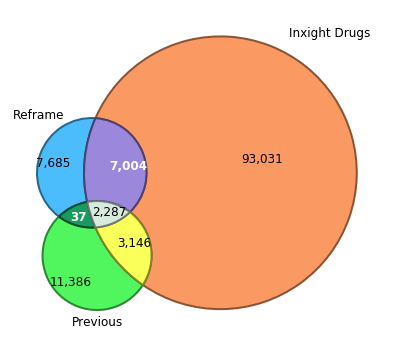

In [152]:
plt.figure(figsize=(10,6))
venn3_pretty([ref_ids, ix_ids, prev_ids], ['Reframe', 'Inxight Drugs', 'Previous'], border=False)

# Time to call in the big string manipulation guns...

In [153]:
import re
pattern = re.compile('[\W_]+')

def strip_chars(string):
    return pattern.sub('', string)

In [154]:
ref.columns

Index(['gvk_id', 'drug_name', 'phase', 'drug_roa', 'category', 'mechanism',
       'sub_smiles', 'synonyms_gvk', 'ikey', 'name_inf', 'highest_phase',
       'moa', 'target_name', 'target_family', 'origin', 'chem_name',
       'smiles_inf', 'key', 'pubchem', 'wikidata_inf', 'informa_id',
       'synonyms_inf', 'id', 'status', 'smiles_itg', 'name_itg',
       'integrity_note', 'int_thera_group', 'int_MoA', 'wikidata_itg',
       'PubChem CID', 'source', 'mesh_id', 'final_id'],
      dtype='object')

In [155]:
# chem_name seems dubious... urea was in one that was clearly not Urea...
name_cols = ['drug_name', 'synonyms_gvk', 'name_inf', 'synonyms_inf', 'name_itg']


name_set = []

for row in ref.itertuples():
    out = set()
    for col in name_cols:
        elem = getattr(row, col)
        if not pd.isnull(elem):
            out.update(set(elem.split('|')))
    name_set.append(set([strip_chars(o).lower() for o in out]))
ref['all_names'] = pd.Series(name_set)
ref.head(2)

,gvk_id,drug_name,phase,drug_roa,category,mechanism,sub_smiles,synonyms_gvk,ikey,name_inf,...,name_itg,integrity_note,int_thera_group,int_MoA,wikidata_itg,PubChem CID,source,mesh_id,final_id,all_names
0,5916161.0,A-49816,Clinical Phase Unknown,NaN,High-Ceiling Diuretic,High-Ceiling Diuretic,Cl[H].[H]OC1=C(CN([H])[H])C=C(C=C1)C(=O)C2=CC=...,Abbott-49816,WYFYYAHANZQLGG-UHFFFAOYSA-N,NaN,...,A-49816,NaN,Diuretics,NaN,Q27270440,CID92009045,gvk|integrity,NaN,WYFYYAHANZQLGG-UHFFFAOYSA-N,"{a49816, abbott49816}"
1,5913712.0,Elmustine,Clinical Phase Unknown,NaN,Anticancer,Anticancer,[H]OCCN([H])C(=O)N(CCCl)N=O,BRN-1956525|FFC-33|HECNU|Hecnu|NSC-294895,YJZJEQBSODVMTH-UHFFFAOYSA-N,Elmustine,...,Elmustine,NaN,Oncolytic Drugs,DNA-Damaging Drugs,Q27284767,CID68804,gvk|informa|integrity,MESH:C013876,MESH:C013876,"{elmustine, ffc33, brn1956525, nsc294895, hecnu}"


In [156]:
ref['all_names'].apply(len).sum()

67172

In [157]:
expand_split_col(ref['all_names'])['all_names'].nunique()

60034

In [158]:
ref['all_names'] = ref['all_names'].apply(list)
ref_exp = expand_df_on_col(ref, 'all_names')
len(ref_exp)

67172

In [159]:
from collections import defaultdict

In [160]:
name_to_ikeys = defaultdict(set)
for name, df in ref_exp.groupby('all_names'):
    name_to_ikeys[name].update(set(df['ikey']))

In [161]:
len(name_to_ikeys)

60034

In [162]:
tups = [(k, len(v)) for k, v in name_to_ikeys.items()]
names = [t[0] for t in tups]
lens = [t[1] for t in tups]

In [163]:
name_len = pd.DataFrame({'names': names, 'lens': lens}).sort_values('lens', ascending=False)
name_len.head(10)

,names,lens
37495,noname,79
12242,ceftobiprolemedocaril,4
32265,m14659,4
47140,ro239424,4
26362,hp228,3
49519,seglitide,3
31314,lometrexol,3
34370,minopafant,3
19227,ebiratide,3
31890,lx2931,3


In [164]:
# Names belonging to more than one ikey
(name_len['lens'] > 1).sum()

6271

In [165]:
# names with fewer than 1 ikey
(name_len['lens'] == 1).sum()

53763

Group the ikeys....

In [166]:
adj_list = defaultdict(set)
for row in ref_exp.itertuples():
    # Skip consolidation of nonames
    if row.all_names != 'noname':
        adj_list[row.final_id].add(row.all_names)
        adj_list[row.all_names].add(row.final_id)

Add in the other sources...

In [167]:
# Add the ctd comps...
for row in prev_comps.itertuples():
    name = strip_chars(row.name).lower()
    adj_list[name].add(row.final_id)
    adj_list[row.final_id].add(name)

In [168]:
# Add all the inxight comps
for row in ix_comps.itertuples():
    if not pd.isnull(row.name):
        name = strip_chars(row.name).lower()
    
        adj_list[name].add(row.final_id)
        adj_list[row.final_id].add(name)

# Expand all the multiple IDs per line... in the inxight drugs
exp_ix_comps = ix_comps.copy()
for c in ix_comps.columns:
    exp_ix_comps = expand_col_on_char(exp_ix_comps, c, '|')
        

In [169]:
# Merge Uniis with names
archive = zipfile.ZipFile(data_dir.joinpath('UNIIs.zip'), 'r')
unii_names = pd.read_csv(archive.open('UNII NAMES 7Mar2019.txt'), sep='\t')
    
ix_mrg = exp_ix_comps.merge(unii_names.dropna(subset=['Name']), how='inner', left_on='unii_id', right_on='UNII')

In [170]:
# Use the synonmyms...
for row in ix_mrg.itertuples():
    name = getattr(row, 'Name')
    if not pd.isnull(name):
        # Some names have superfulous info in a bracket... so strip it out...
        name = name.split('[')[0]
        
        name = strip_chars(name).lower()
        adj_list[name].add(row.final_id)
        adj_list[row.final_id].add(name)

In [171]:
from queue import Queue
from tqdm import tqdm

def get_subnets(adj_list):

    all_identifiers = set(adj_list.keys())

    subnets = defaultdict(set)
    visited = set()

    for _id in tqdm(all_identifiers):
        if _id not in visited:
            visited.add(_id)
            q = Queue()
            q.put(_id)

            while not q.empty():
                cur = q.get()
                visited.add(cur)

                for neighbour in adj_list[cur]:
                    subnets[_id].add(neighbour)
                    if neighbour not in visited:
                        q.put(neighbour)
                        visited.add(neighbour)

    return subnets

In [172]:
subnets = get_subnets(adj_list)

100%|██████████| 787494/787494 [00:08<00:00, 95050.42it/s] 


In [173]:
len(subnets)

108868

In [174]:
# Get the special UNIIs
num_unii = unii_names.dropna()[unii_names.dropna()['UNII'].str.isnumeric()]['UNII'].unique()
alpha_unii = unii_names.dropna()[unii_names.dropna()['UNII'].str.isalpha()]['UNII'].unique()
SPECIAL_UNII = list(num_unii) + list(alpha_unii)    

In [175]:
def is_mesh(mid):
    return mid.startswith('MESH:')
def is_chebi(cid):
    return cid.startswith('CHEBI:')
def is_ikey(ikey):
    return tuple(map(len, ikey.split('-'))) == (14, 10, 1)
def is_drugbank(dbid):
    return dbid.startswith('DB') and len(dbid) == 7

def is_unii(uid):
    # The exact restructions on uniis are non-obvious other than length 10....
    if len(uid) != 10:
        return False
    # The uniis here are all capitalized on the alpha chars...
    if not uid.isupper():
        return False
    
    # Most UNIIs are mix of both alpha and numeric... 
    # Only a handful, of pure alpha, or pure num, so check if doesn't pass initial test...
    return (uid.isalnum() and not uid.isalpha() and not uid.isnumeric()) or uid in SPECIAL_UNII

def is_identifier(val):
    return is_mesh(val) or is_chebi(val) or is_chebi(val) or is_drugbank(val) or is_unii(val)

In [176]:
def get_best_id(list_of_ids, pref_order=None):

    if pref_order is None:
        pref_order = ['mesh', 'chebi', 'ikey', 'drugbank', 'unii']
    
    # Ensure Types
    list_of_ids = list(list_of_ids)


    all_ids = dict()

    # Separate the IDs by type
    all_ids['mesh'] = [i for i in list_of_ids if is_mesh(i)]
    all_ids['chebi'] = [i for i in list_of_ids if is_chebi(i)]
    all_ids['ikey'] = [i for i in list_of_ids if is_ikey(i)]
    all_ids['drugbank'] = [i for i in list_of_ids if is_drugbank(i)]
    all_ids['unii'] = [i for i in list_of_ids if is_unii(i)]
    
    # Find an id of the preferred type.
    for po in pref_order:
        if len(all_ids[po]) > 0:
            return all_ids[po][0]
    
    return list_of_ids[0]


In [177]:
id_to_subnet = {get_best_id(v): v for v in subnets.values()}
old_to_new_id = {v: k for k, vals in id_to_subnet.items() for v in vals}

In [178]:
ref['final_id'] = ref['final_id'].map(old_to_new_id).fillna(ref['ikey'])
ref['final_id'].nunique()

12680

In [179]:
ix_comps['final_id'] = ix_comps['final_id'].map(old_to_new_id)
ix_comps['final_id'].nunique()

97256

In [180]:
ix_comps['final_id'].nunique()

97256

In [181]:
prev_comps['final_id'] = prev_comps['final_id'].map(old_to_new_id)
prev_comps['final_id'].nunique()

16336

In [182]:
ref_ids = set(ref['final_id'])
ix_ids = set(ix_comps['final_id'])
prev_ids = set(prev_comps['final_id'])

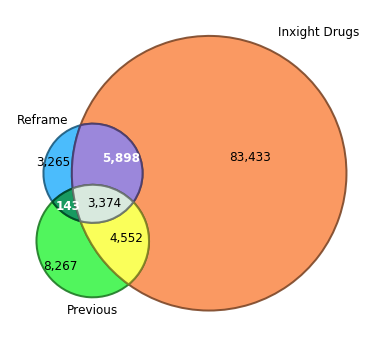

In [183]:
plt.figure(figsize=(10,6))
venn3_pretty([ref_ids, ix_ids, prev_ids], ['Reframe', 'Inxight Drugs', 'Previous'], border=False)

In the final network, we will keep everything expect the Orange region...


In [184]:
keep_ids = ref_ids & prev_ids

In [185]:
prev_comps.head(2)

,id,name,label,tree_numbers,drug_bank_ids,alt_disease_ids,gene_symbol,alt_gene_ids,bio_gridids,pharm_gkbids,uni_prot_ids,uniprot_id,mesh_ids,chebi_ids,final_id
0,MESH:C046983,06-Paris-LA-66 protocol,Compound,D02.455.426.559.847.562.050.200/C046983|D03.13...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MESH:C046983
1,MESH:C534883,10074-G5,Compound,D03.383.129.462.580/C534883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MESH:C534883


In [186]:
ix_comps.head(2)

,id,name,label,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,unii_id,source,final_id
0,FZERHIULMFGESH-UHFFFAOYSA-N,Acetanilide,Compound,CHEBI:28884,CHEMBL269644,NaN,FZERHIULMFGESH-UHFFFAOYSA-N,MESH:C508827,SP86R356CC,ikey,MESH:C508827
1,SWMPGCCDXNLPED-NSCUHMNNSA-N,Acetylfuratrizine,Compound,NaN,NaN,NaN,SWMPGCCDXNLPED-NSCUHMNNSA-N,NaN,C50C4V19SU,ikey,SWMPGCCDXNLPED-NSCUHMNNSA-N


In [187]:
ref_nodes = ref.loc[:, ['final_id', 'source']]
ref_nodes['label'] = 'Drug'
prev_comp_nodes = prev_comps.loc[:, ['final_id', 'name', 'label']]
ix_comp_nodes = ix_comps.loc[:, ['final_id', 'name']].query('final_id in @keep_ids')
ix_comp_nodes['label'] = 'Drug'

In [188]:
compounds = pd.concat([ref_nodes, prev_comp_nodes, ix_comp_nodes], ignore_index=True, sort=False)
compounds = gt.order_cols(compounds.drop_duplicates(subset=['final_id'], keep='first').rename(columns={'final_id': 'id'}))

In [189]:
ref['name'] = ref['drug_name'].fillna(ref['name_inf'].fillna(ref['name_itg']))
id_to_name = chebi.set_index('id')['name'].to_dict()
id_to_name = {**chebi.set_index('mesh')['name'].to_dict(), **id_to_name}
id_to_name = {**chebi.set_index('ikey')['name'].to_dict(), **id_to_name}
id_to_name = {**prev_comps.set_index('id')['name'].to_dict(), **id_to_name}
id_to_name = {**ref.set_index('ikey')['name'].to_dict(), **id_to_name}
id_to_name = {**ref.set_index('mesh_id')['name'].to_dict(), **id_to_name}
id_to_name = {**ix_comps.set_index('id')['name'].to_dict(), **id_to_name}
id_to_name = {**ix_comps.set_index('ikey')['name'].to_dict(), **id_to_name}
id_to_name = {**ix_comps.set_index('unii_id')['name'].to_dict(), **id_to_name}

In [190]:
compounds['name'] = compounds['name'].fillna(compounds['id'].map(id_to_name))

In [191]:
len(compounds)

25499

In [192]:
compounds['label'].value_counts()

Compound    12819
Drug        12680
Name: label, dtype: int64

In [193]:
compounds.head(2)

,id,name,label,source
0,KWDSYQYCWWCCAV-UHFFFAOYSA-N,Abbott-49816,Drug,gvk|integrity
1,MESH:C013876,Elmustine,Drug,gvk|informa|integrity


## Save out our gigantic mapping efforts

In [194]:
map_results = pd.DataFrame({'old_id': list(old_to_new_id.keys()), 'new_id': list(old_to_new_id.values())})

In [195]:
id_map_results = map_results[map_results['old_id'].apply(lambda x: is_identifier(x))].copy()
id_map_results['old_name'] = id_map_results['old_id'].map(id_to_name)
id_map_results['new_name'] = id_map_results['new_id'].map(id_to_name)

max_res = map_results['new_id'].value_counts().index[0]

id_map_results.query('new_id == @max_res')

,old_id,new_id,old_name,new_name
9159,MESH:C014715,MESH:C014715,Norinyl,Norinyl
9273,MESH:D004997,MESH:C014715,17alpha-ethynylestradiol,Norinyl
9309,MESH:D005040,MESH:C014715,ethynodiol diacetate,Norinyl
9322,CHEBI:50900,MESH:C014715,dexonorgestrel,Norinyl
9369,MESH:C036657,MESH:C014715,norlestrin,Norinyl
9372,MESH:D016912,MESH:C014715,levonorgestrel,Norinyl
9420,MESH:C024262,MESH:C014715,norethisterone acetate,Norinyl
9451,MESH:C017576,MESH:C014715,norgestimate,Norinyl
9456,MESH:D009644,MESH:C014715,norgestrel,Norinyl
9516,CHEBI:91741,MESH:C014715,"(10R,13S,17R)-13-ethyl-17-ethynyl-17-hydroxy-1...",Norinyl


In [196]:
vc = id_map_results['new_id'].value_counts()
high_val = vc[vc > 5].index

id_map_results.query('new_id in @high_val')

,old_id,new_id,old_name,new_name
339,CHEBI:51064,MESH:D000661,(S)-amphetamine sulfate,1-phenylpropan-2-amine
343,MESH:D000661,MESH:D000661,1-phenylpropan-2-amine,1-phenylpropan-2-amine
364,CHEBI:51063,MESH:D000661,amphetamine sulfate,1-phenylpropan-2-amine
369,MESH:C090411,MESH:D000661,Adderall,1-phenylpropan-2-amine
466,CHEBI:42724,MESH:D000661,(R)-amphetamine,1-phenylpropan-2-amine
479,MESH:D003913,MESH:D000661,(S)-amphetamine,1-phenylpropan-2-amine
2668,MESH:C047445,MESH:C047445,cefetamet pivoxil,cefetamet pivoxil
2669,B4O7C9XKP1,MESH:C047445,"Dehydroemetine dihydrochloride, (+/-)-",cefetamet pivoxil
2683,MESH:C086742,MESH:C047445,Dehydroemetine,cefetamet pivoxil
2685,CHEBI:31369,MESH:C047445,Cefetamet pivoxil hydrochloride,cefetamet pivoxil


In [197]:
len(high_val)

29

In [198]:
id_map_results.to_csv(out_dir.joinpath('compound_identifier_mapping.csv'), index=False)
compounds.to_csv(out_dir.joinpath('compound_nodes.csv'), index=False)